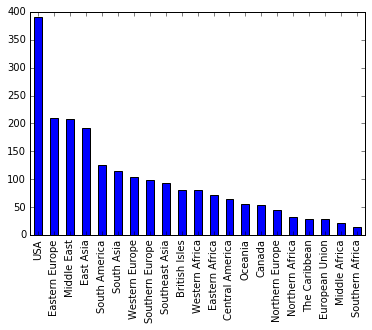

In [17]:
%matplotlib inline
import os.path
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import fftpack
from IPython.display import Audio
from scipy.io import wavfile
from skimage import util
from sklearn.preprocessing import LabelEncoder


RECORDINGS = 'recordings/'
DATA_FILE_NAME = 'speakers_all.csv'
FILE_EXTENSION = '.mp3'
speech_data = pd.read_csv(DATA_FILE_NAME).iloc[:, :-3]

speech_data = speech_data[speech_data['file_missing?'] == False].iloc[:, :-1] # We get rid of the files that don't have a corresponding speech file

MAP_FILE = 'UNcountrygrouping.csv'
map_data = pd.read_csv(MAP_FILE, names=['Country','Region'])
map_data.Country = map_data.Country.str.lower()

speech_data['region'] = speech_data['country'].map(map_data.set_index('Country')['Region'])
pd.value_counts(speech_data['region']).plot.bar()

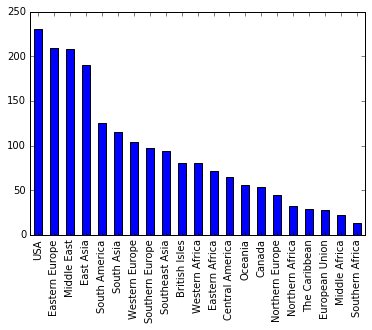

In [18]:
speech_data = speech_data.dropna()
usa = speech_data[speech_data['region'] == 'USA']
females = usa[usa['sex']== 'female'].sample(80)
males = usa[usa['sex'] == 'male'].sample(80)

speech_data.drop(females.index, inplace=True)
speech_data.drop(males.index, inplace = True)

usa = speech_data[speech_data['region'] == 'USA']

speech_data['region'] = speech_data['country'].map(map_data.set_index('Country')['Region'])
pd.value_counts(speech_data['region']).plot.bar()

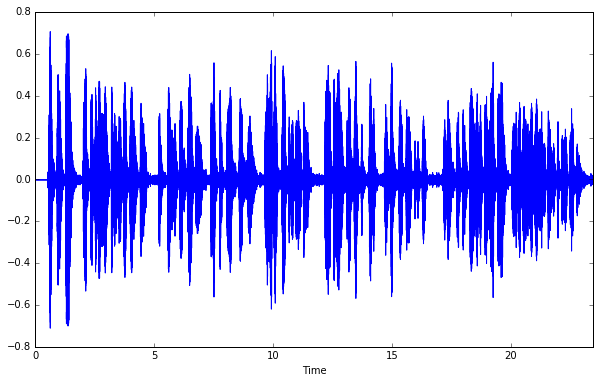

In [19]:
filename = RECORDINGS + 'afrikaans4' + '.mp3'
y, sr = librosa.load(filename, sr=8000)     # y is the audio series and sr in the number of sample per second
plt.figure(figsize=(10,6))
librosa.display.waveplot(y, sr=sr)
plt.show()

101


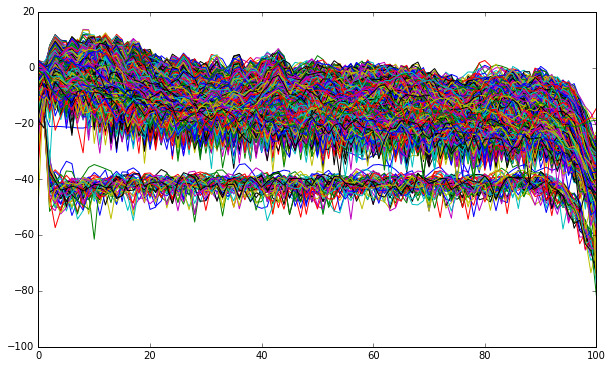

In [20]:
HOP_SIZE = 0.01
WINDOW_SIZE = 0.025
x = librosa.core.stft(y, n_fft=int(sr * WINDOW_SIZE), hop_length=int(HOP_SIZE * sr))
num_bins = x.shape[0]
print(num_bins)
plt.figure(figsize=(10,6))
plt.plot(np.log10(abs(x))*10)
plt.show()

/home/sajid.kamal/anaconda3/lib/python3.5/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


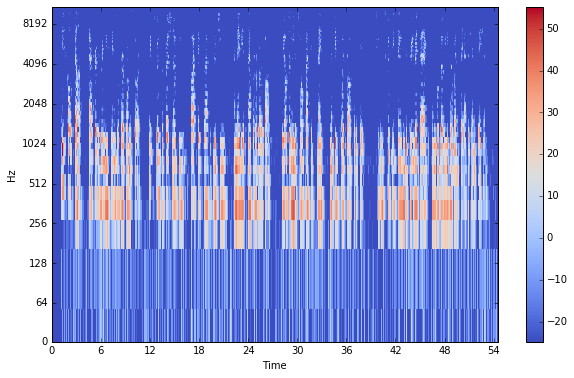

In [21]:
# Calculate log amplitude
example_stft_log_power = librosa.amplitude_to_db(x**2)

# Plot spectrogram
f, ax = plt.subplots(figsize=(10, 6))
librosa.display.specshow(example_stft_log_power, x_axis = 'time', y_axis = 'log')
plt.colorbar()

In [22]:
language_encoder = LabelEncoder()
language_encoder.fit(speech_data['region'])
speech_data['language_encoded'] = language_encoder.transform(speech_data['region'])
speech_data = pd.concat([speech_data.filename, speech_data.speakerid,speech_data.language_encoded], axis=1)
speech_data.columns = [ 'filename', 'speakerid', 'language_encoded']

filename            0
speakerid           0
language_encoded    0
dtype: int64

In [23]:
def fft_process(filename, language_encoding):
    y, sr = librosa.load(RECORDINGS + filename + FILE_EXTENSION, sr=8000)
    ## transpose the stft so we have frequency bins as columns, windows as rows
    x = librosa.core.stft(y, n_fft=int(sr * WINDOW_SIZE), hop_length=int(HOP_SIZE * sr))
    x = abs(x).T
    label_vector = np.full((x.shape[0], 1), language_encoding, dtype=int)
    #print("Freq Bin Shape: ", str(x.shape))
    return x, label_vector

freq_bins_matrix = np.array([]).reshape(0,num_bins)
label_vector = np.array([]).reshape(0,1)
for index, row in speech_data.iterrows():
    if os.path.exists(RECORDINGS + row['filename']+ FILE_EXTENSION):
        bins_data , l_vector = fft_process(row['filename'],row['language_encoded'])
        freq_bins_matrix = np.concatenate((freq_bins_matrix, bins_data))
        label_vector = np.concatenate((label_vector, l_vector))
        print(index)

32
33
34
35
36
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
91
92
93
94
95
96
97
98
99


KeyboardInterrupt: 

In [ ]:
# Implementation of a simple MLP network with one hidden layer. Tested on the iris data set.
# Requires: numpy, sklearn>=0.18.1, tensorflow>=1.0

# NOTE: In order to make the code simple, we rewrite x * W_1 + b_1 = x' * W_1'
# where x' = [x | 1] and W_1' is the matrix W_1 appended with a new row with elements b_1's.
# Similarly, for h * W_2 + b_2
import tensorflow as tf
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)

In [ ]:
iris = datasets.load_iris()
data = freq_bins_matrix
target = label_vector
target

In [ ]:
# Prepend the column of 1s for bias
N, M  = data.shape
all_X = np.ones((N, M + 1))  # The M + 1 represents the bias for each of the feature rows (nodes)
all_X[:, 1:] = data
print(str(N) + ", " + str(M))

In [ ]:
# Convert into one-hot vectors
num_labels = len(np.unique(target))
all_Y = np.eye(num_labels)[target]  # One liner trick!
all_Y

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(all_X, all_Y, test_size=0.33, random_state=RANDOM_SEED)
# Layer's sizes
x_size = train_X.shape[1]   # Number of input nodes: 4 features and 1 bias
HIDDEN_LAYER_SIZE  = 256    # Number of hidden nodes
y_size = train_y.shape[1]   # Number of outcomes (3 iris flowers)

train_y.shape

In [ ]:
# Symbols
X = tf.placeholder("float", shape=[None, x_size])
y = tf.placeholder("float", shape=[None, y_size])

# Weight initializations
weights = tf.random_normal((x_size, HIDDEN_LAYER_SIZE), stddev=0.1) # Initialize the weights randomly
w_1 = tf.Variable(weights)

weights = tf.random_normal((HIDDEN_LAYER_SIZE, y_size), stddev=0.1)
w_2 = tf.Variable(weights)

$ \large \mathbf{x}_{train} =
\begin{bmatrix}
    1       & x_{11} & x_{12} & x_{13} & x_{14} \\
    1       & x_{21} & x_{22} & x_{23} & x_{24} \\
    \vdots & \vdots & \vdots  & \vdots & \vdots\\
    1       & x_{d1} & x_{d2} & x_{d3} & x_{d4}
\end{bmatrix}$

$ \large \mathbf{w} =
\begin{bmatrix}
    w_{11} & w_{12} & \dots  & w_{1n} \\
    w_{21} & w_{22} & \dots  & w_{2n} \\
    w_{31} & w_{32} & \dots  & w_{3n} \\
   w_{41} & w_{42} & \dots  & w_{4n} \\
    w_{51}  & w_{52} & \dots & w_{5n}
\end{bmatrix}$

## Where $n=256$, then you have to multiply each feature with each weight

$ \large \mathbf{x}_{train} \mathbf{w} =
\begin{bmatrix}
    \sigma_{ij} & \dots & \dots  & \sigma_{iN} \\
    \vdots & \ddots & \ddots  & \vdots \\
    \vdots & \ddots & \ddots  & \vdots \\
   \vdots & \ddots & \ddots  & \vdots \\
    \sigma_{ij}  & \dots & \dots & \sigma_{Mj}
\end{bmatrix}$

## Where $\sigma$ is what the activation function will take in and $j$ is each neuron in the hidden layer and $i$ is each sample

$ \large \phi( \mathbf{x}_{train} \mathbf{w}) =
\begin{bmatrix}
    \phi(\sigma_{ij}) & \dots & \dots  & \phi(\sigma_{iN}) \\
    \vdots & \ddots & \ddots  & \vdots \\
    \vdots & \ddots & \ddots  & \vdots \\
   \vdots & \ddots & \ddots  & \vdots \\
    \phi(\sigma_{ij})  & \dots & \dots & \phi(\sigma_{Mj})
\end{bmatrix}$

## Where row $i$ represents the the result of the activation function for each neuron for that particular sample $i$

In [ ]:
# Forward propagation
h = tf.nn.sigmoid(tf.matmul(X, w_1))  # The \sigma function, this does the activation function 
yhat = tf.matmul(h, w_2)              # The \varphi function, The reason why you apply sigmoid is because this will be the output layer (last layer)
                                      # therefore it automatically applies the softmask, if we wanted to add more hidden layers then we would have to apply sigmoid
predict = tf.argmax(yhat, axis=1)     # Take majority vote

# Back propagation
cost    = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat)) # This calculates the loss using some cost function
updates = tf.train.GradientDescentOptimizer(0.01).minimize(cost)                # Perform gradient decent to get the proper updates to the weight to minimize the cost

In [ ]:
# Run SGD
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(100):
# Train with each example
    for i in range(len(train_X)):
        sess.run(updates, feed_dict={X: train_X[i: i + 1], y: train_y[i: i + 1]})

        train_accuracy = np.mean(np.argmax(train_y, axis=1) ==
                                sess.run(predict, feed_dict={X: train_X, y: train_y}))
        test_accuracy  = np.mean(np.argmax(test_y, axis=1) ==
                                sess.run(predict, feed_dict={X: test_X, y: test_y}))

        print("Epoch = %d, train accuracy = %.2f%%, test accuracy = %.2f%%"
            % (epoch + 1, 100. * train_accuracy, 100. * test_accuracy))

sess.close()